In [ ]:
import pandas as pd

# Function to load and clean the dataset
def load_and_clean_data(file_path):
    # Load the dataset
    data = pd.read_csv(file_path)

    # Convert 'Date Reported' and 'Date Occurred' to datetime objects
    data['Date Reported'] = pd.to_datetime(data['Date Reported'])
    data['Date Occurred'] = pd.to_datetime(data['Date Occurred'])

    # Filter the dataset for the relevant time period (2012 to 2023) using 'Date Occurred'
    data['Year Occurred'] = data['Date Occurred'].dt.year
    data_filtered = data[(data['Year Occurred'] >= 2012) & (data['Year Occurred'] <= 2023)]

    # Return the filtered dataset
    return data_filtered

# Function to split the dataset into training and testing sets
def split_data(data_filtered):
    # Split the dataset into training (2012 to 2017) and testing (2018 to 2023)
    train_data = data_filtered[data_filtered['Year Occurred'] <= 2017]
    test_data = data_filtered[data_filtered['Year Occurred'] >= 2018]

    # Aggregating data to get the count of collisions per day
    train_data_aggregated = train_data.groupby('Date Occurred').size()
    test_data_aggregated = test_data.groupby('Date Occurred').size()

    return train_data_aggregated, test_data_aggregated

# Example usage
file_path = 'Traffic_Collision_Data_from_2010_to_Present.csv' # Replace with your file path
data_filtered = load_and_clean_data(file_path)
train_data_aggregated, test_data_aggregated = split_data(data_filtered)


# Display the first few rows of the aggregated data
train_data_aggregated.head(), test_data_aggregated.head()


(Date Occurred
 2012-01-01    101
 2012-01-02     88
 2012-01-03    116
 2012-01-04     96
 2012-01-05    113
 dtype: int64,
 Date Occurred
 2018-01-01    121
 2018-01-02    138
 2018-01-03    120
 2018-01-04    132
 2018-01-05    142
 dtype: int64)

In [ ]:
import statsmodels.api as sm

# ARIMA model
def fit_arima_model(train_data):
    # Fitting an ARIMA model
    # The order (p,d,q) needs to be determined using analysis like ACF and PACF plots
    # For simplicity, we are using an arbitrary order here
    p, d, q = 1, 1, 1  # These are example parameters
    model = sm.tsa.ARIMA(train_data, order=(p, d, q))
    results = model.fit()

    return results

# Fit the ARIMA model on the training data
arima_results = fit_arima_model(train_data_aggregated)

# Summary of the model
arima_summary = arima_results.summary()
arima_summary



/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2192
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -9345.810
Date:                Thu, 30 Nov 2023   AIC                          18697.621
Time:                        17:16:18   BIC                          18714.697
Sample:                    01-01-2012   HQIC                         18703.862
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2457      0.022     11.217      0.000       0.203       0.289
ma.L1         -0.9701      0.006   -172.080      0.000      -0.981      -0.959
sigma2       296.5301      7.720     38.413      0.000     281.400     311.660
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                57.87
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.32   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# Forecasting using the ARIMA model for the test period (2018-2023)
forecast_start = test_data_aggregated.index[0]
forecast_end = test_data_aggregated.index[-1]

# Generate forecasts
arima_forecast = arima_results.predict(start=forecast_start, end=forecast_end)

# Display the first few forecasted values
arima_forecast.head()


2018-01-01    150.403175
2018-01-02    155.416839
2018-01-03    156.648844
2018-01-04    156.951585
2018-01-05    157.025977
Freq: D, Name: predicted_mean, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Truncate the forecast to the length of the test data
arima_forecast_truncated = arima_forecast[:len(test_data_aggregated)]

# Calculate performance metrics
mae = mean_absolute_error(test_data_aggregated, arima_forecast_truncated)
rmse = np.sqrt(mean_squared_error(test_data_aggregated, arima_forecast_truncated))

mae, rmse


(66.41377152544878, 80.61813572911102)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
import warnings

# Define a function for grid search ARIMA parameters
def arima_grid_search(train_data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            model = ARIMA(train_data, order=order)
            results = model.fit()
            aic = results.aic
            if aic < best_score:
                best_score, best_cfg = aic, order
            print('ARIMA%s AIC=%.2f' % (order, aic))
        except:
            continue
    return best_cfg

# ARIMA Configuration
p_values = range(0, 3) # Example range, can be expanded
d_values = range(0, 3)
q_values = range(0, 3)

warnings.filterwarnings("ignore")
best_order = arima_grid_search(train_data_aggregated, p_values, d_values, q_values)

best_order



ARIMA(0, 0, 0) AIC=19971.27
ARIMA(0, 0, 1) AIC=19413.42
ARIMA(0, 0, 2) AIC=19278.92
ARIMA(0, 1, 0) AIC=19662.67
ARIMA(0, 1, 1) AIC=18807.34
ARIMA(0, 1, 2) AIC=18697.98
ARIMA(0, 2, 0) AIC=21851.55
ARIMA(0, 2, 1) AIC=19664.48
ARIMA(0, 2, 2) AIC=18814.40
ARIMA(1, 0, 0) AIC=19136.59
ARIMA(1, 0, 1) AIC=18814.98
ARIMA(1, 0, 2) AIC=18708.94
ARIMA(1, 1, 0) AIC=19354.15
ARIMA(1, 1, 1) AIC=18697.62
ARIMA(1, 1, 2) AIC=18698.25
ARIMA(1, 2, 0) AIC=20923.90
ARIMA(1, 2, 1) AIC=19356.63
ARIMA(1, 2, 2) AIC=18705.08
ARIMA(2, 0, 0) AIC=19061.90
ARIMA(2, 0, 1) AIC=18709.07
ARIMA(2, 0, 2) AIC=18709.49
ARIMA(2, 1, 0) AIC=19158.21
ARIMA(2, 1, 1) AIC=18698.43
ARIMA(2, 1, 2) AIC=18700.03
ARIMA(2, 2, 0) AIC=20388.00
ARIMA(2, 2, 1) AIC=19161.29
ARIMA(2, 2, 2) AIC=18707.04


(1, 1, 1)

In [ ]:
# Extended Grid Search with a wider range of parameters for ARIMA model
p_values = range(0, 5)  # Extended range
d_values = range(0, 3)
q_values = range(0, 5)

best_order_extended = arima_grid_search(train_data_aggregated, p_values, d_values, q_values)
best_order_extended



ARIMA(0, 0, 0) AIC=19971.27
ARIMA(0, 0, 1) AIC=19413.42
ARIMA(0, 0, 2) AIC=19278.92
ARIMA(0, 0, 3) AIC=19176.30
ARIMA(0, 0, 4) AIC=19107.80
ARIMA(0, 1, 0) AIC=19662.67
ARIMA(0, 1, 1) AIC=18807.34
ARIMA(0, 1, 2) AIC=18697.98
ARIMA(0, 1, 3) AIC=18698.49
ARIMA(0, 1, 4) AIC=18699.73
ARIMA(0, 2, 0) AIC=21851.55
ARIMA(0, 2, 1) AIC=19664.48
ARIMA(0, 2, 2) AIC=18814.40
ARIMA(0, 2, 3) AIC=18705.56
ARIMA(0, 2, 4) AIC=18706.10
ARIMA(1, 0, 0) AIC=19136.59
ARIMA(1, 0, 1) AIC=18814.98
ARIMA(1, 0, 2) AIC=18708.94
ARIMA(1, 0, 3) AIC=18709.67
ARIMA(1, 0, 4) AIC=18711.08
ARIMA(1, 1, 0) AIC=19354.15
ARIMA(1, 1, 1) AIC=18697.62
ARIMA(1, 1, 2) AIC=18698.25
ARIMA(1, 1, 3) AIC=18694.11
ARIMA(1, 1, 4) AIC=18701.70
ARIMA(1, 2, 0) AIC=20923.90
ARIMA(1, 2, 1) AIC=19356.63
ARIMA(1, 2, 2) AIC=18705.08
ARIMA(1, 2, 3) AIC=18813.73
ARIMA(1, 2, 4) AIC=18707.88
ARIMA(2, 0, 0) AIC=19061.90
ARIMA(2, 0, 1) AIC=18709.07
ARIMA(2, 0, 2) AIC=18709.49
ARIMA(2, 0, 3) AIC=18711.24
ARIMA(2, 0, 4) AIC=18712.83
ARIMA(2, 1, 0) AIC=1

(2, 1, 4)

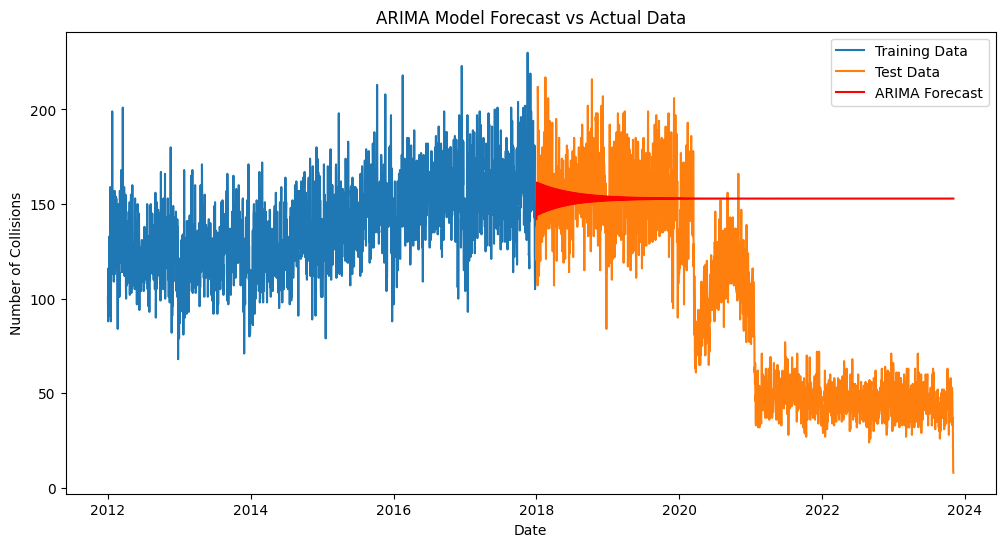

In [ ]:
import matplotlib.pyplot as plt

# Fit the best ARIMA model from the extended grid search
best_arima_model = ARIMA(train_data_aggregated, order=(2, 1, 4))
best_arima_results = best_arima_model.fit()

# Forecasting using the best ARIMA model
best_arima_forecast = best_arima_results.predict(start=forecast_start, end=forecast_end)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(train_data_aggregated, label='Training Data')
plt.plot(test_data_aggregated, label='Test Data')
plt.plot(best_arima_forecast, label='ARIMA Forecast', color='red')
plt.title('ARIMA Model Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()


<Figure size 1200x600 with 0 Axes>

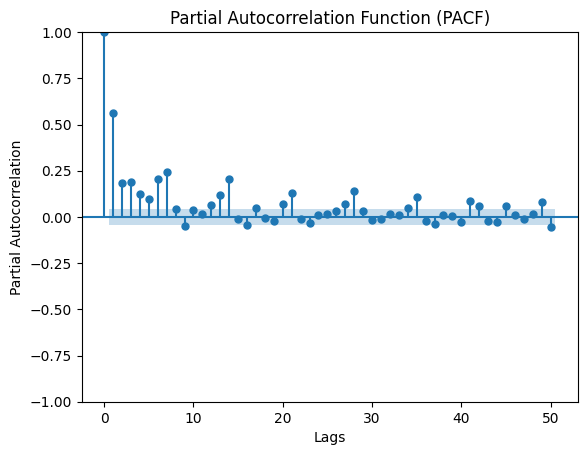

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plotting the Partial Autocorrelation Function (PACF)
plt.figure(figsize=(12, 6))
plot_pacf(train_data_aggregated, lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.show()


<Figure size 1200x600 with 0 Axes>

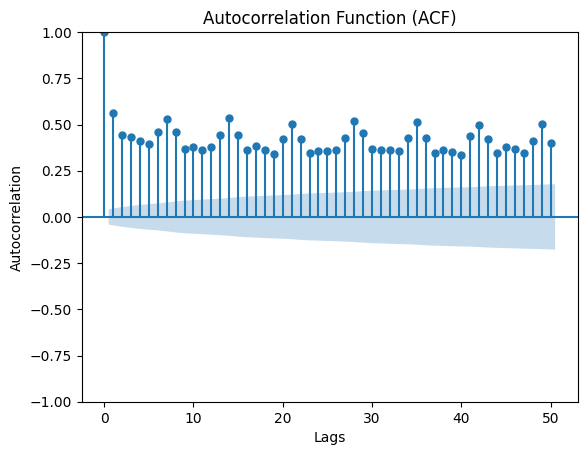

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plotting the Autocorrelation Function (ACF)
plt.figure(figsize=(12, 6))
plot_acf(train_data_aggregated, lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Constructing the SARIMA model
# Using the previously determined best non-seasonal parameters (2, 1, 4)
# Initial seasonal parameters based on the ACF and PACF analysis
# Assuming a season length of 10 based on the ACF and PACF plots
P, D, Q, S = 1, 1, 1, 10  # These are initial guesses and might need refinement

# Fit the SARIMA model
sarima_model = SARIMAX(train_data_aggregated, order=(2, 1, 4), seasonal_order=(P, D, Q, S))
sarima_results = sarima_model.fit()

# Summary of the SARIMA model
sarima_summary = sarima_results.summary()
sarima_summary



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 2192
Model:             SARIMAX(2, 1, 4)x(1, 1, [1], 10)   Log Likelihood               -9327.546
Date:                              Thu, 30 Nov 2023   AIC                          18673.093
Time:                                      17:18:33   BIC                          18724.281
Sample:                                  01-01-2012   HQIC                         18691.805
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0396      0.036     -1.095      0.273      -0.110       0.031
ar.L2          0.9574      0.037     26.009      0.000       0.885       1.030
ma.L1         -0.6934      0.049    -14.047      0.000      -0.790      -0.597
ma.L2         -1.1934      0.064    -18.601      0.000      -1.319      -1.068
ma.L3          0.6927      0.038     18.454      0.000       0.619       0.766
ma.L4          0.1956      0.026      7.543      0.000       0.145       0.246
ar.S.L10      -0.0442      0.024     -1.877      0.061      -0.090       0.002
ma.S.L10      -0.9982      0.038    -26.351      0.000      -1.072      -0.924
sigma2       296.4710     13.125     22.587      0.000     270.746     322.196
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                31.58
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

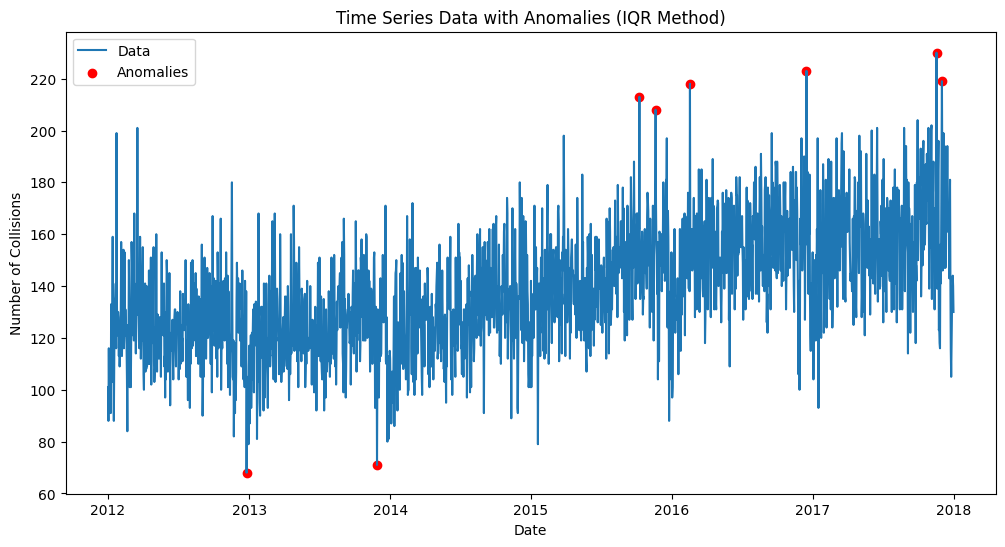

Date Occurred
2012-12-25     68
2013-11-28     71
2015-10-09    213
2015-11-20    208
2016-02-17    218
2016-12-15    223
2017-11-17    230
2017-12-01    219
dtype: int64


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'train_data_aggregated' is your time series data
# Load your data here if it's not already loaded
# Example: train_data_aggregated = pd.read_csv('your_data.csv')

# Calculating IQR for anomaly detection
Q1 = train_data_aggregated.quantile(0.25)
Q3 = train_data_aggregated.quantile(0.75)
IQR = Q3 - Q1

# Defining the bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identifying anomalies
anomalies_iqr = train_data_aggregated[(train_data_aggregated < lower_bound) | (train_data_aggregated > upper_bound)]

# Plotting the data with anomalies identified using IQR
plt.figure(figsize=(12, 6))
plt.plot(train_data_aggregated, label='Data')
plt.scatter(anomalies_iqr.index, anomalies_iqr, color='red', label='Anomalies')
plt.title('Time Series Data with Anomalies (IQR Method)')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()

# Output the anomalies
print(anomalies_iqr)


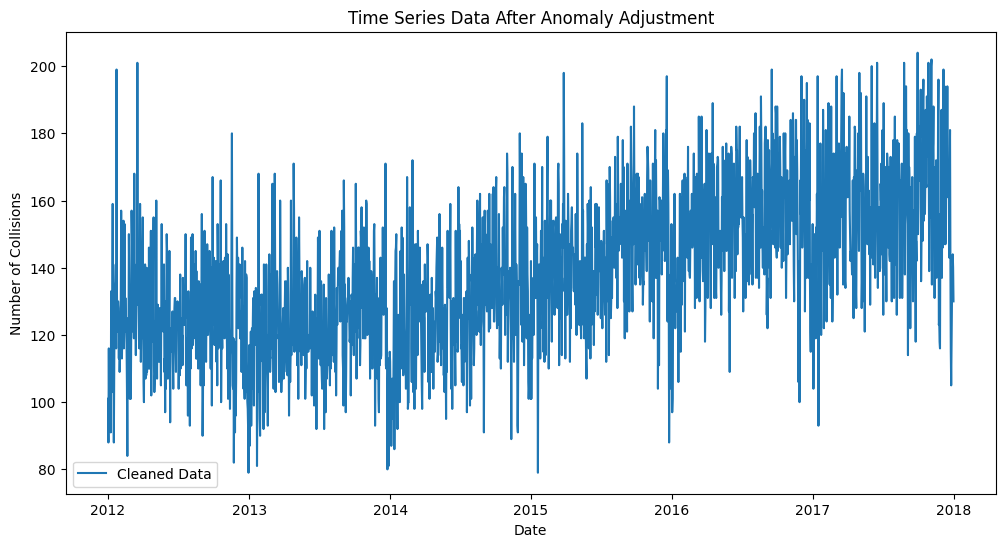

In [ ]:
# Replace anomalies with the median of the dataset
median_value = train_data_aggregated.median()
train_data_cleaned = train_data_aggregated.copy()
train_data_cleaned[anomalies_iqr.index] = median_value

# Plotting the cleaned data
plt.figure(figsize=(12, 6))
plt.plot(train_data_cleaned, label='Cleaned Data')
plt.title('Time Series Data After Anomaly Adjustment')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.9 MB/s eta 0:00:00


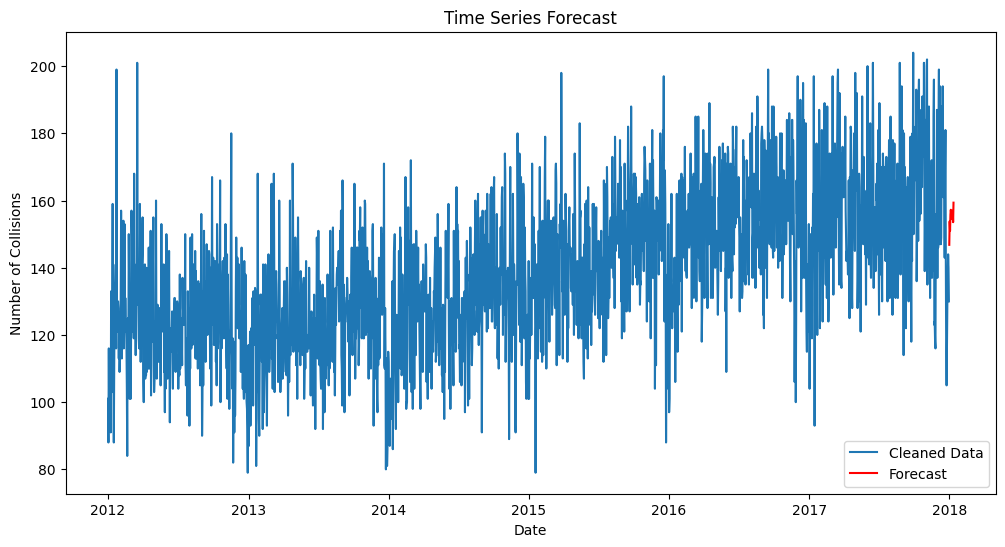

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Load your time series data
# train_data_aggregated = pd.read_csv('path_to_your_data.csv')

# Replace anomalies with the median value
median_value = train_data_aggregated.median()
train_data_cleaned = train_data_aggregated.copy()
train_data_cleaned.loc[anomalies_iqr.index] = median_value

# Perform auto ARIMA to find the best model on the cleaned dataset
auto_arima_model = auto_arima(train_data_cleaned, seasonal=True, m=12, suppress_warnings=True)

# Fit the SARIMA model using the best parameters from auto ARIMA
sarima_model = SARIMAX(train_data_cleaned, order=auto_arima_model.order,
                       seasonal_order=auto_arima_model.seasonal_order)
sarima_results = sarima_model.fit()

# Forecasting
forecast = sarima_results.get_forecast(steps=12)  # For example, forecast 12 steps ahead
forecast_index = pd.date_range(start=train_data_cleaned.index[-1], periods=13, closed='right')
forecast_series = pd.Series(forecast.predicted_mean, index=forecast_index)

# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(train_data_cleaned, label='Cleaned Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.title('Time Series Forecast')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()


Since the datashows a shift in the last 3 years, we will attempt to split the data and focus on the last 3 years forecast. 2021,2022 will be the training data and will use 2023 as test data.

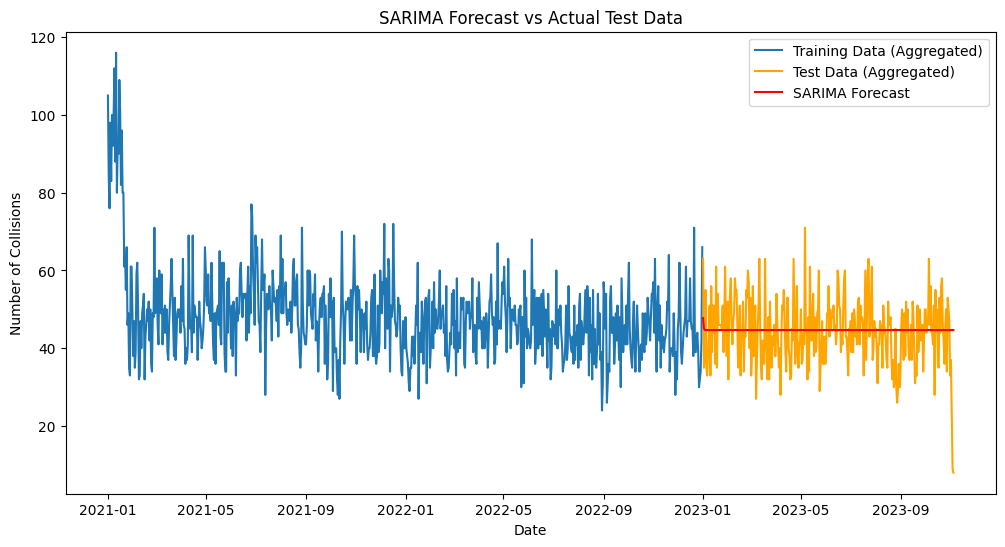

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# Load and clean the dataset
def load_and_clean_data(file_path):
    data = pd.read_csv(file_path)
    data['Date Reported'] = pd.to_datetime(data['Date Reported'])
    data['Date Occurred'] = pd.to_datetime(data['Date Occurred'])
    data['Year Occurred'] = data['Date Occurred'].dt.year
    data_filtered = data[(data['Year Occurred'] >= 2012) & (data['Year Occurred'] <= 2023)]
    return data_filtered

# Split the dataset into training and testing sets
def split_data(data_filtered):
    train_data = data_filtered[(data_filtered['Year Occurred'] >= 2021) & (data_filtered['Year Occurred'] <= 2022)]
    test_data = data_filtered[data_filtered['Year Occurred'] == 2023]
    train_data_aggregated = train_data.groupby('Date Occurred').size()
    test_data_aggregated = test_data.groupby('Date Occurred').size()
    return train_data_aggregated, test_data_aggregated

# Load your data
file_path = '20231108.csv'  # Replace with your file path
data_filtered = load_and_clean_data(file_path)
train_data_agg, test_data_agg = split_data(data_filtered)

# Anomaly Detection using IQR on the training set
Q1 = train_data_agg.quantile(0.25)
Q3 = train_data_agg.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace anomalies with the median value of the training set
train_data_cleaned = train_data_agg.copy()
anomalies = train_data_cleaned[(train_data_cleaned < lower_bound) | (train_data_cleaned > upper_bound)]
train_data_cleaned[anomalies.index] = train_data_cleaned.median()

# Train the time series model using auto ARIMA on the cleaned training set
auto_arima_model_sarima = auto_arima(train_data_cleaned, seasonal=True, m=12, suppress_warnings=True)

# Fit the SARIMA model using the best parameters from auto ARIMA
sarima_model_fit = SARIMAX(train_data_cleaned, order=auto_arima_model_sarima.order,
                           seasonal_order=auto_arima_model_sarima.seasonal_order)
sarima_results_fit = sarima_model_fit.fit()

# Forecasting for the year 2023 up to November
forecast_steps_sarima = len(test_data_agg)
forecast_sarima = sarima_results_fit.get_forecast(steps=forecast_steps_sarima)
forecast_series_sarima = pd.Series(forecast_sarima.predicted_mean, index=test_data_agg.index)

# Plot the forecast against the actual test data
plt.figure(figsize=(12, 6))
plt.plot(train_data_agg, label='Training Data (Aggregated)')
plt.plot(test_data_agg, label='Test Data (Aggregated)', color='orange')
plt.plot(forecast_series_sarima, label='SARIMA Forecast', color='red')
plt.title('SARIMA Forecast vs Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()



Cross-validation MAE for SARIMA:  6.757918637996619


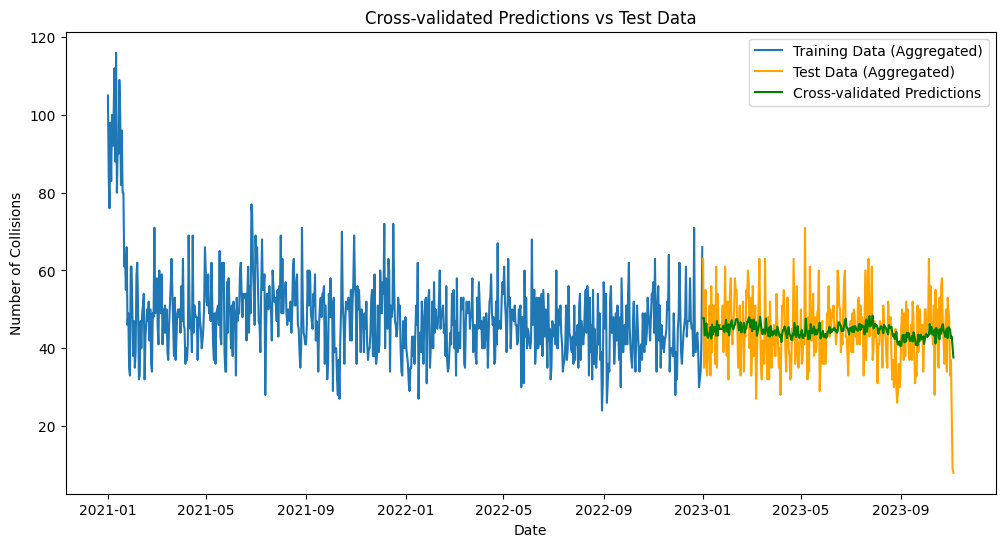

In [ ]:
def time_series_cv_sarima(train_series, test_series, order, seasonal_order):
    history = [x for x in train_series]
    predictions = list()
    test_dates = test_series.index

    # Walk-forward validation over the test set using static parameters
    for t in range(len(test_series)):
        model_fit = SARIMAX(history, order=order, seasonal_order=seasonal_order).fit(disp=0)
        yhat = model_fit.predict(start=len(history), end=len(history), dynamic=False)[0]
        predictions.append(yhat)
        history.append(test_series.iloc[t])

    predictions_series = pd.Series(predictions, index=test_dates)
    mae = mean_absolute_error(test_series, predictions_series)
    return predictions_series, mae

# Perform cross-validation with static parameters
cv_predictions_sarima, cv_mae_sarima = time_series_cv_sarima(train_data_cleaned, test_data_agg,
                                                             order=auto_arima_model_sarima.order,
                                                             seasonal_order=auto_arima_model_sarima.seasonal_order)


# Print the cross-validation MAE
print('Cross-validation MAE for SARIMA: ', cv_mae_sarima)

# Plot the cross-validated predictions against actual values
plt.figure(figsize=(12, 6))
plt.plot(train_data_agg, label='Training Data (Aggregated)')
plt.plot(test_data_agg, label='Test Data (Aggregated)', color='orange')
plt.plot(cv_predictions_sarima, label='Cross-validated Predictions', color='green')
plt.title('Cross-validated Predictions vs Test Data')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()

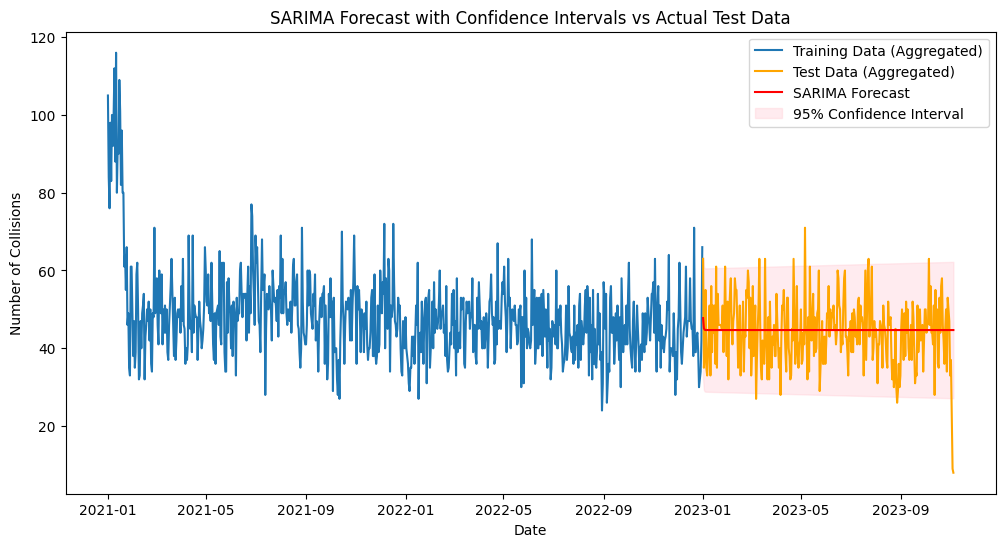

In [ ]:
# Forecasting for the year 2023 up to November with confidence intervals
forecast_sarima = sarima_results_fit.get_forecast(steps=forecast_steps_sarima)
forecast_series_sarima = pd.Series(forecast_sarima.predicted_mean, index=test_data_agg.index)
confidence_intervals = forecast_sarima.conf_int()

# Plot the forecast against the actual test data with confidence intervals
plt.figure(figsize=(12, 6))
plt.plot(train_data_agg, label='Training Data (Aggregated)')
plt.plot(test_data_agg, label='Test Data (Aggregated)', color='orange')
plt.plot(forecast_series_sarima, label='SARIMA Forecast', color='red')
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMA Forecast with Confidence Intervals vs Actual Test Data')
plt.xlabel('Date')
plt.ylabel('Number of Collisions')
plt.legend()
plt.show()
